In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
#
import pandas

In [3]:
from hpc_lib import *
#
# get header, print a few rows:
#data_file_name = 'data/sacct_out.out'
#data_file_name = 'data/sacct_mazama_out.out'
data_file_name = 'data/sacct_sherlock_out_hns.out'
#
# translation dictionary. Note the column input parameters (aka, --format=...) are not the same as
#.  the colunm names.
#
# with -p --delimiter='|', we get:
#. ['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End',
#'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', '']
#
# how well does PANDAS automagically handle types? Maybe we should just add all available columns to this:
# NOTE: System-,User-,Total-CPU is a string with multiple values (time, energy, etc.)
types_dict={'User':str, 'JobID':str, 'JobName':str, 'Partition':str, 'State':str,
            'Timelimit':str,'Start':str2date, 'End':str2date, 'Submit':str2date, 'Elapsed':elapsed_time_2_sec, 'MaxRSS':str,
            'MaxVMSize':str, 'NNodes':int, 'NCPUS':int, 'MinCPU':str, 'SystemCPU':str, 'UserCPU':str,
            'TotalCPU':str}
delim = '|'

In [4]:
# TODO: can we make this work? it will be faster, but 1) we need to reformat some... most? of the data,
#. and 2) we might need to throw out some extra header rows, depending on how we collect our data.
data_df2 = pandas.read_csv(data_file_name, sep='|')


/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print('** ', data_df2.columns )
print('** ', len(data_df2.columns))
#
for s in data_df2.columns:
    print('** ', s)

**  Index(['User', 'Group', 'GID', 'JobID', 'JobName', 'Partition', 'State',
       'Submit', 'Timelimit', 'Eligible', 'Start', 'End', 'Elapsed', 'MaxRSS',
       'MaxVMSize', 'NNodes', 'NCPUS', 'SystemCPU', 'UserCPU', 'TotalCPU',
       'Suspended', 'Unnamed: 21'],
      dtype='object')
**  22
**  User
**  Group
**  GID
**  JobID
**  JobName
**  Partition
**  State
**  Submit
**  Timelimit
**  Eligible
**  Start
**  End
**  Elapsed
**  MaxRSS
**  MaxVMSize
**  NNodes
**  NCPUS
**  SystemCPU
**  UserCPU
**  TotalCPU
**  Suspended
**  Unnamed: 21


### HPC Usage data
- Presently focused on Mazama
- Usage data drawn via:
```
--format=User,JobID,Jobname,partition,state,time,start,end,elapsed,MaxRss,MaxVMSize,nnodes,ncpus
```
- Generally, type conversions will need to be performed manually
- But since we might change the columns of interest, let's code up a dictionary of functions to do the translation

In [6]:
#
with open(data_file_name, 'r') as fin:
    # NOTE: lines end with a delimiter, so dump the last value.
    #
    headers = fin.readline()[:-1].split(delim)
    delim_lines=fin.readline()
    #
    #print('*** headers: ', headers)
    #
    teasers = []
    for k in range(10):
        #print('**')
        #teasers += [fin.readline()[:-1].split()]
        teasers += [fin.readline()[:-2]]
#
print('headers: ', headers)
for k,rw in enumerate(teasers):
    print('{}: {}'.format(k,rw))

headers:  ['User', 'Group', 'GID', 'JobID', 'JobName', 'Partition', 'State', 'Submit', 'Timelimit', 'Eligible', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', 'SystemCPU', 'UserCPU', 'TotalCPU', 'Suspended', '']
0: |||47861384.extern|extern||COMPLETED|2019-08-10T00:57:02||2019-08-10T00:57:02|2019-08-10T00:57:02|2019-08-17T00:57:29|7-00:00:27|0|107952K|1|20|00:00.001|00:00:00|00:00.001|00:00:00
1: ippoliti|vkhemani|357497|48057259_930|test|hns|COMPLETED|2019-08-12T15:03:44|2-00:00:00|2019-08-12T15:03:45|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|||1|1|24:49.090|1-23:00:48|1-23:25:37|00:00:00
2: |||48057259_930.batch|batch||COMPLETED|2019-08-14T02:04:17||2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|393204K|177940K|1|1|24:49.089|1-23:00:48|1-23:25:37|00:00:00
3: |||48057259_930.extern|extern||COMPLETED|2019-08-14T02:04:17||2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|0|107952K|1|1|00:00.001|00:00:00|00:00.00

In [7]:
#Read the whole data file:
#
#max_rows=1000
max_rows = None
#
with open(data_file_name, 'r') as fin:
    headers_rw = fin.readline()
    print('*** headers_rw: ', headers_rw)
    headers = headers_rw[:-1].split(delim)[:-1]
    RH = {h:k for k,h in enumerate(headers)}
    #
    delim_lines=fin.readline()
    #
    print('*** headers: ', headers)
    active_headers=headers
    # TODO: it would be a nice performance boost to only work through a subset of the headers...
    #active_headers = [cl for cl in headers if cl in types_dict.keys()]
    #
    #
    data = []
    n_rws = 0
    # TODO: multithread this:
    for j,rw in enumerate(fin):
        #
        if rw[0:10] == headers_rw[0:10]:
            continue
        #
        n_rws += 1
        #if not (max_rows is None or max_rows<0) and j>max_rows:
        if not (max_rows is None or max_rows<0) and n_rws>max_rows:
            break
        
        #print('*** DEBUG: ', rw)
        data += [rw.split(delim)[:-1]]
        #print('* * DEBUG: ', data[-1])
        #
        #for k, (col,vl) in enumerate(zip(headers, data[-1])):
        for k, (col,vl) in enumerate(zip(active_headers, data[-1])):
            #print('j,k [{}:{}]: {}, {}'.format(col,vl, j,k))
            #data[-1][k]=types_dict[col](vl)
            data[-1][k]=types_dict.get(col, str)(vl)
        #
        #
#
print('** len: ', len(data))

*** headers_rw:  User|Group|GID|JobID|JobName|Partition|State|Submit|Timelimit|Eligible|Start|End|Elapsed|MaxRSS|MaxVMSize|NNodes|NCPUS|SystemCPU|UserCPU|TotalCPU|Suspended|

*** headers:  ['User', 'Group', 'GID', 'JobID', 'JobName', 'Partition', 'State', 'Submit', 'Timelimit', 'Eligible', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', 'SystemCPU', 'UserCPU', 'TotalCPU', 'Suspended']
** len:  1710724


In [8]:
data_df = pandas.DataFrame(data, columns=active_headers)

In [9]:
# unique completion states:
#
#states = sorted(list(set([rw[RH['State']]  for rw in data])))
states = sorted(list(set(data_df['State'])))
for s in states:
    print('** {}'.format(s))


** CANCELLED
** CANCELLED by 20475
** CANCELLED by 22178
** CANCELLED by 236036
** CANCELLED by 238060
** CANCELLED by 238782
** CANCELLED by 240198
** CANCELLED by 243866
** CANCELLED by 24485
** CANCELLED by 246982
** CANCELLED by 247127
** CANCELLED by 255640
** CANCELLED by 256744
** CANCELLED by 256862
** CANCELLED by 257593
** CANCELLED by 258572
** CANCELLED by 260401
** CANCELLED by 260514
** CANCELLED by 260613
** CANCELLED by 270412
** CANCELLED by 271187
** CANCELLED by 273166
** CANCELLED by 274965
** CANCELLED by 275482
** CANCELLED by 275792
** CANCELLED by 275883
** CANCELLED by 276342
** CANCELLED by 277043
** CANCELLED by 278274
** CANCELLED by 278599
** CANCELLED by 278739
** CANCELLED by 278948
** CANCELLED by 279047
** CANCELLED by 279061
** CANCELLED by 279333
** CANCELLED by 279489
** CANCELLED by 282232
** CANCELLED by 285397
** CANCELLED by 28622
** CANCELLED by 287583
** CANCELLED by 287752
** CANCELLED by 287761
** CANCELLED by 289046
** CANCELLED by 290261
**

In [121]:
# for rw in data_df[0:20]:
#     print('** ', rw)

print(data_df['JobID'][0:20])
#
for k, jid in enumerate(data_df['JobID']):
    if len(jid.split('.'))==1: continue
    if jid.split('.')[1] in ('0', '1', '2', '3', '4'):
        print(' ** :: {}, {}'.format(k, jid))


0         47861384.extern
1            48057259_930
2      48057259_930.batch
3     48057259_930.extern
4            48057259_931
5      48057259_931.batch
6     48057259_931.extern
7            48057259_932
8      48057259_932.batch
9     48057259_932.extern
10           48057259_933
11     48057259_933.batch
12    48057259_933.extern
13           48057259_934
14     48057259_934.batch
15    48057259_934.extern
16           48057259_935
17     48057259_935.batch
18    48057259_935.extern
19               48130541
Name: JobID, dtype: object
 ** :: 67, 48268824.0
 ** :: 70, 48270204.0
 ** :: 71, 48270204.1
 ** :: 153, 48250747.1
 ** :: 190, 48328782.0
 ** :: 203, 48333365.0
 ** :: 207, 48333388.0
 ** :: 3703, 48357903_0.0
 ** :: 4376, 48373525.0
 ** :: 4504, 48374061_56.0
 ** :: 4601, 48384775_78.0
 ** :: 4605, 48384775_79.0
 ** :: 10599, 48476060.0
 ** :: 10604, 48476631.0
 ** :: 11560, 48493170.0
 ** :: 12550, 48504326.0
 ** :: 14448, 48520861.0
 ** :: 14961, 48522104.0
 ** :: 14983, 

 ** :: 110077, 49375598.0
 ** :: 110081, 49375603.0
 ** :: 110085, 49375606.0
 ** :: 110089, 49375608.0
 ** :: 110093, 49375609.0
 ** :: 110097, 49375613.0
 ** :: 110101, 49375615.0
 ** :: 110105, 49375617.0
 ** :: 110109, 49375618.0
 ** :: 110113, 49375620.0
 ** :: 110117, 49375621.0
 ** :: 110121, 49375623.0
 ** :: 110128, 49375627.0
 ** :: 110132, 49375629.0
 ** :: 110136, 49375631.0
 ** :: 110140, 49375633.0
 ** :: 110144, 49375722.0
 ** :: 110148, 49375724.0
 ** :: 110152, 49375726.0
 ** :: 110156, 49375727.0
 ** :: 110163, 49375731.0
 ** :: 110167, 49375733.0
 ** :: 110171, 49375734.0
 ** :: 110175, 49375736.0
 ** :: 110179, 49375738.0
 ** :: 110183, 49375739.0
 ** :: 110187, 49375741.0
 ** :: 110191, 49375743.0
 ** :: 110195, 49375744.0
 ** :: 110199, 49375746.0
 ** :: 110203, 49375748.0
 ** :: 110207, 49375782.0
 ** :: 110211, 49375784.0
 ** :: 110215, 49375786.0
 ** :: 110219, 49375788.0
 ** :: 110223, 49375790.0
 ** :: 110227, 49375792.0
 ** :: 110231, 49375794.0
 ** :: 11023

 ** :: 218589, 50627476_4.0
 ** :: 218593, 50627578_0.0
 ** :: 218597, 50627578_2.0
 ** :: 218601, 50627578_4.0
 ** :: 218605, 50627578_6.0
 ** :: 218609, 50627578_8.0
 ** :: 218613, 50627578_10.0
 ** :: 218629, 50629325_1.0
 ** :: 218636, 50631062.0
 ** :: 218640, 50631065.0
 ** :: 218644, 50631066.0
 ** :: 218648, 50631068.0
 ** :: 218652, 50631069.0
 ** :: 218656, 50631070.0
 ** :: 218660, 50631072.0
 ** :: 218664, 50631073.0
 ** :: 218668, 50631074.0
 ** :: 218672, 50631075.0
 ** :: 218676, 50631874_7.0
 ** :: 218680, 50631874_9.0
 ** :: 218684, 50631874_11.0
 ** :: 218990, 50657867.0
 ** :: 219483, 50678831.0
 ** :: 219490, 50678834.0
 ** :: 219494, 50678836.0
 ** :: 219497, 50678838.0
 ** :: 219500, 50678941.0
 ** :: 219504, 50678966.0
 ** :: 219508, 50679069.0
 ** :: 219512, 50679077.0
 ** :: 219516, 50679079.0
 ** :: 219520, 50679082.0
 ** :: 219524, 50679843.0
 ** :: 219528, 50679847.0
 ** :: 219532, 50679849.0
 ** :: 219536, 50679855.0
 ** :: 219540, 50679856.0
 ** :: 219544,

 ** :: 273779, 51387386_2.0
 ** :: 273780, 51387386_2.1
 ** :: 273781, 51387386_2.2
 ** :: 273782, 51387386_2.3
 ** :: 273783, 51387386_2.4
 ** :: 273802, 51387386_3.0
 ** :: 273803, 51387386_3.1
 ** :: 273804, 51387386_3.2
 ** :: 273805, 51387386_3.3
 ** :: 273806, 51387386_3.4
 ** :: 273825, 51387386_4.0
 ** :: 273826, 51387386_4.1
 ** :: 273827, 51387386_4.2
 ** :: 273828, 51387386_4.3
 ** :: 273829, 51387386_4.4
 ** :: 273848, 51387387_1.0
 ** :: 273849, 51387387_1.1
 ** :: 273850, 51387387_1.2
 ** :: 273851, 51387387_1.3
 ** :: 273852, 51387387_1.4
 ** :: 273871, 51387387_2.0
 ** :: 273872, 51387387_2.1
 ** :: 273873, 51387387_2.2
 ** :: 273874, 51387387_2.3
 ** :: 273875, 51387387_2.4
 ** :: 273894, 51387387_3.0
 ** :: 273895, 51387387_3.1
 ** :: 273896, 51387387_3.2
 ** :: 273897, 51387387_3.3
 ** :: 273898, 51387387_3.4
 ** :: 273917, 51387387_4.0
 ** :: 273918, 51387387_4.1
 ** :: 273919, 51387387_4.2
 ** :: 273920, 51387387_4.3
 ** :: 273921, 51387387_4.4
 ** :: 273940, 51387

 ** :: 280125, 51389777_1.3
 ** :: 280126, 51389777_1.4
 ** :: 280145, 51389777_2.0
 ** :: 280146, 51389777_2.1
 ** :: 280147, 51389777_2.2
 ** :: 280148, 51389777_2.3
 ** :: 280149, 51389777_2.4
 ** :: 280168, 51389777_3.0
 ** :: 280169, 51389777_3.1
 ** :: 280170, 51389777_3.2
 ** :: 280171, 51389777_3.3
 ** :: 280172, 51389777_3.4
 ** :: 280191, 51389777_4.0
 ** :: 280192, 51389777_4.1
 ** :: 280193, 51389777_4.2
 ** :: 280194, 51389777_4.3
 ** :: 280195, 51389777_4.4
 ** :: 280214, 51389779_1.0
 ** :: 280215, 51389779_1.1
 ** :: 280216, 51389779_1.2
 ** :: 280217, 51389779_1.3
 ** :: 280218, 51389779_1.4
 ** :: 280237, 51389779_2.0
 ** :: 280238, 51389779_2.1
 ** :: 280239, 51389779_2.2
 ** :: 280240, 51389779_2.3
 ** :: 280241, 51389779_2.4
 ** :: 280260, 51389779_3.0
 ** :: 280261, 51389779_3.1
 ** :: 280262, 51389779_3.2
 ** :: 280263, 51389779_3.3
 ** :: 280264, 51389779_3.4
 ** :: 280283, 51389779_4.0
 ** :: 280284, 51389779_4.1
 ** :: 280285, 51389779_4.2
 ** :: 280286, 51389

 ** :: 337590, 51724931.0
 ** :: 351276, 51760057.0
 ** :: 357033, 51766008.0
 ** :: 357886, 51768042.0
 ** :: 357917, 51768064.0
 ** :: 357954, 51768091.0
 ** :: 357997, 51768120.0
 ** :: 358016, 51768142.0
 ** :: 358062, 51768176.0
 ** :: 358099, 51768205.0
 ** :: 358106, 51768209.0
 ** :: 358161, 51768249.0
 ** :: 358222, 51768295.0
 ** :: 358962, 51773498.0
 ** :: 359245, 51776167.0
 ** :: 359249, 51776228.0
 ** :: 359253, 51776248.0
 ** :: 359257, 51776259.0
 ** :: 359261, 51776272.0
 ** :: 359265, 51776329.0
 ** :: 359269, 51776352.0
 ** :: 359273, 51776379.0
 ** :: 359277, 51776407.0
 ** :: 359281, 51776418.0
 ** :: 360234, 51784486_0.0
 ** :: 360238, 51784486_1.0
 ** :: 360242, 51784486_2.0
 ** :: 360246, 51784486_3.0
 ** :: 360265, 51784720_1.0
 ** :: 360269, 51784720_2.0
 ** :: 360273, 51784720_3.0
 ** :: 360690, 51789773.0
 ** :: 360708, 51789826.0
 ** :: 360933, 51790739_0.0
 ** :: 360937, 51790739_5.0
 ** :: 360941, 51790827_0.0
 ** :: 360945, 51790827_1.0
 ** :: 360949, 5

 ** :: 471996, 52782167_2.0
 ** :: 472000, 52782167_3.0
 ** :: 472004, 52782167_4.0
 ** :: 472008, 52782167_5.0
 ** :: 472012, 52782167_6.0
 ** :: 472016, 52782167_7.0
 ** :: 472020, 52782167_8.0
 ** :: 472024, 52782167_9.0
 ** :: 472028, 52782167_10.0
 ** :: 472032, 52782167_11.0
 ** :: 472036, 52782167_12.0
 ** :: 472040, 52782167_13.0
 ** :: 472044, 52782167_14.0
 ** :: 472048, 52782167_15.0
 ** :: 472052, 52782167_16.0
 ** :: 472056, 52782167_17.0
 ** :: 472060, 52782167_18.0
 ** :: 472064, 52782167_19.0
 ** :: 472068, 52782167_20.0
 ** :: 472072, 52782167_21.0
 ** :: 472076, 52782167_22.0
 ** :: 472080, 52782167_23.0
 ** :: 472084, 52782167_24.0
 ** :: 472088, 52782167_25.0
 ** :: 472092, 52782167_26.0
 ** :: 472096, 52782167_27.0
 ** :: 472100, 52782167_28.0
 ** :: 472104, 52782167_29.0
 ** :: 472108, 52782167_30.0
 ** :: 472112, 52782167_31.0
 ** :: 472116, 52782167_32.0
 ** :: 472120, 52782167_33.0
 ** :: 472124, 52782167_34.0
 ** :: 472128, 52782167_35.0
 ** :: 472132, 5278216

 ** :: 604055, 53885630.0
 ** :: 604059, 53885631.0
 ** :: 604063, 53885646.0
 ** :: 604067, 53885655.0
 ** :: 604071, 53885667.0
 ** :: 604075, 53885669.0
 ** :: 604079, 53885670.0
 ** :: 604083, 53885671.0
 ** :: 604087, 53885672.0
 ** :: 604091, 53885673.0
 ** :: 604095, 53885674.0
 ** :: 604099, 53885675.0
 ** :: 604103, 53885676.0
 ** :: 604107, 53885677.0
 ** :: 604111, 53885678.0
 ** :: 604115, 53885679.0
 ** :: 604119, 53885680.0
 ** :: 604123, 53885681.0
 ** :: 604127, 53885683.0
 ** :: 604131, 53885684.0
 ** :: 604135, 53885685.0
 ** :: 604139, 53885686.0
 ** :: 604143, 53885687.0
 ** :: 604147, 53885700.0
 ** :: 604151, 53885703.0
 ** :: 604155, 53885705.0
 ** :: 604159, 53885707.0
 ** :: 604163, 53885709.0
 ** :: 604167, 53885710.0
 ** :: 604171, 53885711.0
 ** :: 604175, 53885712.0
 ** :: 604179, 53885713.0
 ** :: 604183, 53885718.0
 ** :: 604187, 53885720.0
 ** :: 604191, 53885726.0
 ** :: 604195, 53885733.0
 ** :: 604199, 53885734.0
 ** :: 604203, 53885741.0
 ** :: 60420

 ** :: 634703, 54174375_494.0
 ** :: 634707, 54174375_495.0
 ** :: 634711, 54174375_496.0
 ** :: 634715, 54174375_497.0
 ** :: 634719, 54174375_498.0
 ** :: 634723, 54174375_499.0
 ** :: 634727, 54174375_500.0
 ** :: 634731, 54174375_501.0
 ** :: 634735, 54174375_502.0
 ** :: 634739, 54174375_503.0
 ** :: 634743, 54174375_504.0
 ** :: 634747, 54174375_505.0
 ** :: 634751, 54174375_506.0
 ** :: 634755, 54174375_507.0
 ** :: 634759, 54174375_508.0
 ** :: 634763, 54174375_509.0
 ** :: 634767, 54174375_510.0
 ** :: 634771, 54174375_511.0
 ** :: 634775, 54174375_512.0
 ** :: 634779, 54174375_513.0
 ** :: 634783, 54174375_514.0
 ** :: 634787, 54174375_515.0
 ** :: 634791, 54174375_516.0
 ** :: 634795, 54174375_517.0
 ** :: 634799, 54174375_518.0
 ** :: 634803, 54174375_519.0
 ** :: 634807, 54174375_520.0
 ** :: 634811, 54174375_521.0
 ** :: 634815, 54174375_522.0
 ** :: 634819, 54174375_523.0
 ** :: 634823, 54174375_524.0
 ** :: 634827, 54174375_525.0
 ** :: 634831, 54174375_526.0
 ** :: 634

 ** :: 677388, 54474293_157.0
 ** :: 677392, 54474293_172.0
 ** :: 677396, 54474293_173.0
 ** :: 677400, 54474293_174.0
 ** :: 677404, 54474293_175.0
 ** :: 677408, 54474293_176.0
 ** :: 677412, 54474293_177.0
 ** :: 677416, 54474293_179.0
 ** :: 677420, 54474293_180.0
 ** :: 677424, 54474293_181.0
 ** :: 677428, 54474293_182.0
 ** :: 677432, 54474293_183.0
 ** :: 677436, 54474293_184.0
 ** :: 677440, 54474293_185.0
 ** :: 677444, 54474293_186.0
 ** :: 677448, 54474293_187.0
 ** :: 677452, 54474293_188.0
 ** :: 677456, 54474293_189.0
 ** :: 677460, 54474293_190.0
 ** :: 677464, 54474293_191.0
 ** :: 677468, 54474293_192.0
 ** :: 677472, 54474293_193.0
 ** :: 677476, 54474293_194.0
 ** :: 677480, 54474293_195.0
 ** :: 677484, 54474293_196.0
 ** :: 677488, 54474293_197.0
 ** :: 677492, 54474293_198.0
 ** :: 677496, 54474293_199.0
 ** :: 677500, 54474293_201.0
 ** :: 677504, 54474293_202.0
 ** :: 677508, 54474293_203.0
 ** :: 677512, 54474293_204.0
 ** :: 677516, 54474293_205.0
 ** :: 677

 ** :: 747710, 55015578_1.0
 ** :: 747714, 55015578_2.0
 ** :: 747718, 55015578_3.0
 ** :: 747722, 55015578_4.0
 ** :: 747726, 55015578_5.0
 ** :: 747730, 55015578_6.0
 ** :: 747734, 55015578_7.0
 ** :: 747738, 55015578_8.0
 ** :: 747742, 55015578_9.0
 ** :: 747746, 55015578_10.0
 ** :: 747750, 55015578_11.0
 ** :: 747754, 55015578_12.0
 ** :: 747758, 55015578_13.0
 ** :: 747762, 55015578_14.0
 ** :: 747766, 55015578_15.0
 ** :: 747770, 55015578_16.0
 ** :: 747774, 55015578_17.0
 ** :: 747778, 55015578_18.0
 ** :: 747782, 55015578_19.0
 ** :: 747786, 55015578_20.0
 ** :: 747790, 55015578_21.0
 ** :: 747794, 55015578_22.0
 ** :: 747798, 55015578_23.0
 ** :: 747802, 55015578_24.0
 ** :: 747806, 55015578_25.0
 ** :: 747810, 55015578_26.0
 ** :: 747814, 55015578_27.0
 ** :: 747818, 55015578_28.0
 ** :: 747822, 55015578_29.0
 ** :: 747826, 55015578_30.0
 ** :: 747830, 55015578_31.0
 ** :: 747834, 55015578_32.0
 ** :: 747838, 55015578_33.0
 ** :: 747842, 55015578_34.0
 ** :: 747846, 55015578

 ** :: 784133, 55133914_359.0
 ** :: 784137, 55133914_360.0
 ** :: 784141, 55133914_361.0
 ** :: 784145, 55133914_362.0
 ** :: 784149, 55133914_363.0
 ** :: 784153, 55133914_364.0
 ** :: 784157, 55133914_365.0
 ** :: 784161, 55133914_366.0
 ** :: 784165, 55133914_367.0
 ** :: 784169, 55133914_368.0
 ** :: 784173, 55133914_369.0
 ** :: 784177, 55133914_370.0
 ** :: 784181, 55133914_371.0
 ** :: 784185, 55133914_372.0
 ** :: 784189, 55133914_373.0
 ** :: 784193, 55133914_374.0
 ** :: 784197, 55133914_375.0
 ** :: 784201, 55133914_376.0
 ** :: 784205, 55133914_377.0
 ** :: 784209, 55133914_378.0
 ** :: 784213, 55133914_379.0
 ** :: 784217, 55133914_380.0
 ** :: 784221, 55133914_381.0
 ** :: 784225, 55133914_382.0
 ** :: 784229, 55133914_383.0
 ** :: 784233, 55133914_384.0
 ** :: 784237, 55133914_385.0
 ** :: 784241, 55133914_386.0
 ** :: 784245, 55133914_387.0
 ** :: 784249, 55133914_388.0
 ** :: 784253, 55133914_389.0
 ** :: 784257, 55133914_390.0
 ** :: 784261, 55133914_391.0
 ** :: 784

 ** :: 813198, 55351934_497.0
 ** :: 813202, 55351934_498.0
 ** :: 813206, 55351934_499.0
 ** :: 813210, 55351934_500.0
 ** :: 813214, 55351934_501.0
 ** :: 813218, 55351934_502.0
 ** :: 813222, 55351934_503.0
 ** :: 813226, 55351934_504.0
 ** :: 813230, 55351934_505.0
 ** :: 813234, 55351934_506.0
 ** :: 813238, 55351934_507.0
 ** :: 813242, 55351934_508.0
 ** :: 813246, 55351934_509.0
 ** :: 813250, 55351934_510.0
 ** :: 813254, 55351934_511.0
 ** :: 813258, 55351934_512.0
 ** :: 813262, 55351934_513.0
 ** :: 813266, 55351934_514.0
 ** :: 813270, 55351934_515.0
 ** :: 813274, 55351934_516.0
 ** :: 813278, 55351934_517.0
 ** :: 813282, 55351934_518.0
 ** :: 813286, 55351934_519.0
 ** :: 813290, 55351934_520.0
 ** :: 813294, 55351934_521.0
 ** :: 813298, 55351934_522.0
 ** :: 813302, 55351934_523.0
 ** :: 813306, 55351934_524.0
 ** :: 813310, 55351934_525.0
 ** :: 813314, 55351934_526.0
 ** :: 813318, 55351934_527.0
 ** :: 813322, 55351934_528.0
 ** :: 813326, 55351934_529.0
 ** :: 813

 ** :: 832465, 55563809.0
 ** :: 832468, 55567452.0
 ** :: 834480, 55594743_6.0
 ** :: 834484, 55594743_7.0
 ** :: 834488, 55594743_8.0
 ** :: 834492, 55594743_9.0
 ** :: 834496, 55594743_10.0
 ** :: 834503, 55594854_1.0
 ** :: 834507, 55594854_2.0
 ** :: 834511, 55594854_3.0
 ** :: 834515, 55594854_4.0
 ** :: 834519, 55594854_5.0
 ** :: 834523, 55594854_6.0
 ** :: 834527, 55594854_7.0
 ** :: 834531, 55594854_8.0
 ** :: 834535, 55594854_9.0
 ** :: 834539, 55594854_10.0
 ** :: 835506, 55636937_3.0
 ** :: 835510, 55636937_4.0
 ** :: 835514, 55636937_5.0
 ** :: 835518, 55636937_6.0
 ** :: 835522, 55636937_7.0
 ** :: 835526, 55636937_8.0
 ** :: 835530, 55636937_9.0
 ** :: 835534, 55636937_10.0
 ** :: 835811, 55642288.0
 ** :: 835824, 55645834_12.0
 ** :: 835828, 55645834_13.0
 ** :: 835832, 55645834_14.0
 ** :: 835836, 55645834_15.0
 ** :: 835840, 55645834_16.0
 ** :: 835844, 55645834_17.0
 ** :: 835848, 55645834_18.0
 ** :: 835852, 55645834_19.0
 ** :: 835856, 55645834_20.0
 ** :: 835860,

 ** :: 904479, 56322827_7.0
 ** :: 904483, 56322827_12.0
 ** :: 904487, 56322827_13.0
 ** :: 904491, 56322827_14.0
 ** :: 904495, 56322827_16.0
 ** :: 904499, 56322827_18.0
 ** :: 904503, 56322827_20.0
 ** :: 904507, 56322827_21.0
 ** :: 904511, 56322827_22.0
 ** :: 904515, 56322827_23.0
 ** :: 904519, 56322827_24.0
 ** :: 904523, 56322827_25.0
 ** :: 904527, 56322827_27.0
 ** :: 904531, 56322827_28.0
 ** :: 904535, 56322827_29.0
 ** :: 904539, 56322827_30.0
 ** :: 904543, 56322827_33.0
 ** :: 904547, 56322827_34.0
 ** :: 904551, 56322827_35.0
 ** :: 904555, 56322827_36.0
 ** :: 904559, 56322827_37.0
 ** :: 904563, 56322827_38.0
 ** :: 904567, 56322827_39.0
 ** :: 904571, 56322827_40.0
 ** :: 904575, 56322827_41.0
 ** :: 904579, 56322827_42.0
 ** :: 904583, 56322827_43.0
 ** :: 904587, 56322827_44.0
 ** :: 904591, 56322827_45.0
 ** :: 904595, 56322827_48.0
 ** :: 904599, 56322827_49.0
 ** :: 904603, 56322827_50.0
 ** :: 904607, 56322827_51.0
 ** :: 904611, 56322827_53.0
 ** :: 904615, 

 ** :: 1083908, 57631189.0
 ** :: 1087305, 57636101.0
 ** :: 1087408, 57637028.0
 ** :: 1090363, 57649342.0
 ** :: 1091302, 57652171.0
 ** :: 1093852, 57655419.0
 ** :: 1136521, 57733171.0
 ** :: 1136878, 57738233.0
 ** :: 1138384, 57742562.0
 ** :: 1141571, 57778875.0
 ** :: 1141850, 57781628.0
 ** :: 1141853, 57781977.0
 ** :: 1142613, 57793281.0
 ** :: 1142614, 57793281.1
 ** :: 1142615, 57793281.2
 ** :: 1142616, 57793281.3
 ** :: 1142617, 57793281.4
 ** :: 1143099, 57806367.0
 ** :: 1143103, 57806386.0
 ** :: 1143313, 57808904.0
 ** :: 1143505, 57814070.0
 ** :: 1143675, 57815292.0
 ** :: 1145403, 57830917.0
 ** :: 1153565, 57919335_1.0
 ** :: 1153569, 57919335_2.0
 ** :: 1153573, 57919335_3.0
 ** :: 1153577, 57919335_4.0
 ** :: 1153581, 57919335_5.0
 ** :: 1153585, 57919335_6.0
 ** :: 1153589, 57919335_7.0
 ** :: 1153593, 57919335_8.0
 ** :: 1153597, 57919335_9.0
 ** :: 1153601, 57919335_10.0
 ** :: 1153605, 57919335_11.0
 ** :: 1153609, 57919335_12.0
 ** :: 1153613, 57919335_13.

 ** :: 1222779, 58599188_624.0
 ** :: 1222783, 58599188_625.0
 ** :: 1223198, 58599188_431.0
 ** :: 1227877, 58609231_1.0
 ** :: 1227881, 58609231_2.0
 ** :: 1227885, 58609231_3.0
 ** :: 1227889, 58609231_4.0
 ** :: 1227893, 58609231_5.0
 ** :: 1227897, 58609231_6.0
 ** :: 1227901, 58609231_7.0
 ** :: 1227905, 58609231_8.0
 ** :: 1227909, 58609231_9.0
 ** :: 1227913, 58609231_10.0
 ** :: 1227917, 58609231_11.0
 ** :: 1227921, 58609231_12.0
 ** :: 1227925, 58609231_13.0
 ** :: 1227929, 58609231_14.0
 ** :: 1227933, 58609231_15.0
 ** :: 1227937, 58609231_16.0
 ** :: 1227941, 58609231_17.0
 ** :: 1227945, 58609231_18.0
 ** :: 1227949, 58609231_19.0
 ** :: 1227953, 58609231_20.0
 ** :: 1227957, 58609231_21.0
 ** :: 1227961, 58609231_22.0
 ** :: 1227965, 58609231_23.0
 ** :: 1227969, 58609231_24.0
 ** :: 1227973, 58609231_25.0
 ** :: 1227977, 58609231_26.0
 ** :: 1227981, 58609231_27.0
 ** :: 1227985, 58609231_28.0
 ** :: 1227989, 58609231_29.0
 ** :: 1227993, 58609231_30.0
 ** :: 1227997, 

 ** :: 1361069, 59635842.0
 ** :: 1361070, 59635842.1
 ** :: 1361071, 59635842.2
 ** :: 1361072, 59635842.3
 ** :: 1361073, 59635842.4
 ** :: 1361092, 59637151.0
 ** :: 1361093, 59637151.1
 ** :: 1361094, 59637151.2
 ** :: 1361095, 59637151.3
 ** :: 1361096, 59637151.4
 ** :: 1361100, 59637225.0
 ** :: 1361101, 59637225.1
 ** :: 1361102, 59637225.2
 ** :: 1361103, 59637225.3
 ** :: 1361104, 59637225.4
 ** :: 1361108, 59637264.0
 ** :: 1361109, 59637264.1
 ** :: 1361110, 59637264.2
 ** :: 1361111, 59637264.3
 ** :: 1361112, 59637264.4
 ** :: 1361116, 59637353.0
 ** :: 1361117, 59637353.1
 ** :: 1361118, 59637353.2
 ** :: 1361119, 59637353.3
 ** :: 1361120, 59637353.4
 ** :: 1361124, 59637485.0
 ** :: 1361125, 59637485.1
 ** :: 1361126, 59637485.2
 ** :: 1361127, 59637485.3
 ** :: 1361128, 59637485.4
 ** :: 1361132, 59637646.0
 ** :: 1361133, 59637646.1
 ** :: 1361134, 59637646.2
 ** :: 1361135, 59637646.3
 ** :: 1361136, 59637646.4
 ** :: 1361140, 59637766.0
 ** :: 1361141, 59637766.1
 

 ** :: 1500076, 60289429.0
 ** :: 1500775, 60292013.0
 ** :: 1503256, 60300900.0
 ** :: 1503260, 60301039.0
 ** :: 1503270, 60303085.0
 ** :: 1503273, 60303619.0
 ** :: 1503283, 60304305.0
 ** :: 1511085, 60339824.0
 ** :: 1511092, 60340293.0
 ** :: 1511096, 60341421.0
 ** :: 1511100, 60341990.0
 ** :: 1511105, 60345947.0
 ** :: 1511109, 60348581.0
 ** :: 1511113, 60348626.0
 ** :: 1511117, 60348654.0
 ** :: 1511121, 60348663.0
 ** :: 1511125, 60348695.0
 ** :: 1511129, 60348713.0
 ** :: 1511133, 60348852.0
 ** :: 1511137, 60348878.0
 ** :: 1511141, 60348917.0
 ** :: 1511148, 60349280.0
 ** :: 1511494, 60350463.0
 ** :: 1527275, 60407741.0
 ** :: 1527279, 60407746.0
 ** :: 1527286, 60407750.0
 ** :: 1527290, 60407754.0
 ** :: 1527294, 60407757.0
 ** :: 1527298, 60407761.0
 ** :: 1527302, 60407776.0
 ** :: 1527306, 60407778.0
 ** :: 1527313, 60407783.0
 ** :: 1527317, 60407788.0
 ** :: 1527324, 60407794.0
 ** :: 1527328, 60407796.0
 ** :: 1527332, 60407800.0
 ** :: 1527336, 60407802.0
 

 ** :: 1629330, 60635263_388.0
 ** :: 1629334, 60635263_389.0
 ** :: 1629338, 60635263_390.0
 ** :: 1629342, 60635263_391.0
 ** :: 1629346, 60635263_392.0
 ** :: 1629350, 60635263_393.0
 ** :: 1629354, 60635263_394.0
 ** :: 1629358, 60635263_395.0
 ** :: 1629362, 60635263_396.0
 ** :: 1629366, 60635263_397.0
 ** :: 1629370, 60635263_398.0
 ** :: 1629374, 60635263_399.0
 ** :: 1629378, 60635263_400.0
 ** :: 1629382, 60635263_401.0
 ** :: 1629386, 60635263_402.0
 ** :: 1629390, 60635263_403.0
 ** :: 1629394, 60635263_404.0
 ** :: 1629398, 60635263_405.0
 ** :: 1629402, 60635263_406.0
 ** :: 1629406, 60635263_407.0
 ** :: 1629410, 60635263_408.0
 ** :: 1629414, 60635263_409.0
 ** :: 1629418, 60635263_410.0
 ** :: 1629422, 60635263_411.0
 ** :: 1629426, 60635263_412.0
 ** :: 1629430, 60635263_413.0
 ** :: 1629434, 60635263_414.0
 ** :: 1629438, 60635263_415.0
 ** :: 1629442, 60635263_416.0
 ** :: 1629446, 60635263_417.0
 ** :: 1629450, 60635263_418.0
 ** :: 1629454, 60635263_419.0
 ** :: 1

 ** :: 1671992, 60728312_390.0
 ** :: 1671996, 60728312_391.0
 ** :: 1672000, 60728312_392.0
 ** :: 1672004, 60728312_393.0
 ** :: 1672008, 60728312_394.0
 ** :: 1672012, 60728312_395.0
 ** :: 1672016, 60728312_396.0
 ** :: 1672020, 60728312_397.0
 ** :: 1672024, 60728312_398.0
 ** :: 1672028, 60728312_399.0
 ** :: 1672032, 60728312_400.0
 ** :: 1672036, 60728312_401.0
 ** :: 1672040, 60728312_402.0
 ** :: 1672044, 60728312_403.0
 ** :: 1672048, 60728312_404.0
 ** :: 1672052, 60728312_405.0
 ** :: 1672056, 60728312_406.0
 ** :: 1672060, 60728312_407.0
 ** :: 1672064, 60728312_408.0
 ** :: 1672068, 60728312_409.0
 ** :: 1672072, 60728312_410.0
 ** :: 1672076, 60728312_411.0
 ** :: 1672080, 60728312_412.0
 ** :: 1672084, 60728312_413.0
 ** :: 1672088, 60728312_414.0
 ** :: 1672092, 60728312_415.0
 ** :: 1672096, 60728312_416.0
 ** :: 1672100, 60728312_417.0
 ** :: 1672104, 60728312_418.0
 ** :: 1672108, 60728312_419.0
 ** :: 1672112, 60728312_420.0
 ** :: 1672116, 60728312_421.0
 ** :: 1

 ** :: 1700795, 60845344_2.0
 ** :: 1700799, 60845344_3.0
 ** :: 1700803, 60845344_4.0
 ** :: 1700807, 60845344_5.0
 ** :: 1700811, 60845344_6.0
 ** :: 1700815, 60845344_7.0
 ** :: 1700819, 60845344_8.0
 ** :: 1700823, 60845344_9.0
 ** :: 1700827, 60845344_10.0
 ** :: 1700831, 60845344_11.0
 ** :: 1700835, 60845344_12.0
 ** :: 1700839, 60845344_13.0
 ** :: 1700843, 60845344_14.0
 ** :: 1700847, 60845344_15.0
 ** :: 1700851, 60845344_16.0
 ** :: 1700855, 60845344_17.0
 ** :: 1700859, 60845344_18.0
 ** :: 1700863, 60845344_19.0
 ** :: 1700867, 60845344_20.0
 ** :: 1700871, 60845344_21.0
 ** :: 1700875, 60845344_22.0
 ** :: 1700879, 60845344_23.0
 ** :: 1700883, 60845344_24.0
 ** :: 1700887, 60845344_25.0
 ** :: 1700891, 60845344_26.0
 ** :: 1700895, 60845344_27.0
 ** :: 1700899, 60845344_28.0
 ** :: 1700903, 60845344_29.0
 ** :: 1700907, 60845344_30.0
 ** :: 1700911, 60845344_31.0
 ** :: 1700915, 60845344_32.0
 ** :: 1700919, 60845344_33.0
 ** :: 1700923, 60845344_34.0
 ** :: 1700927, 60

In [135]:
print('** {}\n'.format(headers))
# for rw in data[0:100]:
#     if rw[RH['JobID']].split('.')[0]=='48057259_930':
#         print('** {}\n'.format(rw['Job']))
#
# this_jid = '48057259_930'
this_jid = '48693050'
this_jid = '48538697'
for rw in data:
    #print('** ', rw)
    #print('* * ', rw[RH['JobID']])
    #print('** ', rw[RH['JobID']].split('.'))
    #if rw[RH['JobID']].split('.')[0]==this_jid:
    if rw[RH['JobID']].startswith(this_jid) or rw[RH['JobID']] == this_jid:
        #print('** {}'.format(rw[RH['JobID']]))
        jid = rw[RH['JobID']]
        #jid_0, jid_1 = rw[RH['JobID']].split('_')
        # 'batch', 'extern', 
        if len(jid.split('.'))>=2 and jid.split('.')[1] in ('batch', 'extern', 'bogus_place_holder'):
            continue
        print('** {}\n'.format([rw[RH[s]] for s in ('User', 'Group', 'JobID', 'Submit', 'Timelimit',
                                  'Eligible', 'Start', 'End', 'Elapsed', 'NCPUS')]))

** ['User', 'Group', 'GID', 'JobID', 'JobName', 'Partition', 'State', 'Submit', 'Timelimit', 'Eligible', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', 'SystemCPU', 'UserCPU', 'TotalCPU', 'Suspended']

** ['gda', 'skachru', '48538697_0', datetime.datetime(2019, 8, 18, 21, 37, 45, tzinfo=datetime.timezone.utc), '00:55:00', '2019-08-18T21:37:47', datetime.datetime(2019, 8, 18, 21, 37, 48, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 8, 18, 21, 44, 20, tzinfo=datetime.timezone.utc), 392.0, 7]

** ['gda', 'skachru', '48538697_1', datetime.datetime(2019, 8, 18, 21, 37, 45, tzinfo=datetime.timezone.utc), '00:55:00', '2019-08-18T21:37:47', datetime.datetime(2019, 8, 18, 21, 37, 48, tzinfo=datetime.timezone.utc), datetime.datetime(2019, 8, 18, 21, 44, 26, tzinfo=datetime.timezone.utc), 398.0, 7]

** ['gda', 'skachru', '48538697_2', datetime.datetime(2019, 8, 18, 21, 37, 45, tzinfo=datetime.timezone.utc), '00:55:00', '2019-08-18T21:37:47', datetime.datetime(2019,

In [113]:
print('** ', 'abc'.split('.'), 'abc'.split('.')[0])
print('** ', 'abc'.split('.')[0]=='abc')

**  ['abc'] abc
**  True


### Active CPUs:
- TODO: this is overcounting cpus, because there is a row for each step in the job, but each step shows the full start/stop time.
- We need to consolidate unique jobIDs.

In [143]:
#
### how 'bout a time series of sum(ncpu) RUNNING?
#
# TODO: consider states COMPLETED, FAILED, RUNNING, TIMEOUT, PENDING. These all represent workload; only exclude
#. canceled jobs.
#ix = numpy.array([rw[RH['State']] in ['COMPLETED', 'RUNNING'] for rw in data])
#ix = numpy.logical_or( data_df['State']=='COMPLETED', data_df['State']=='RUNNING')
#ix = numpy.ones(len(data_df)).astype(bool)
ix = numpy.array(['.batch' not in s and '.extern' not in s for s in data_df['JobID']])
ix = numpy.array(['.' not in s for s in data_df['JobID']])
#
#
t_now = mpd.date2num(dtm.datetime.now())
t_start = mpd.date2num(data_df['Start'][ix])
#
t_end = data_df['End'][ix].to_numpy()
t_end[t_end is None]=t_now
t_end=mpd.date2num(t_end)
#
n_cpu = data_df['NCPUS'][ix].to_numpy()

start_end = numpy.array([t_start, t_end]).T
#
# sort on t_start:
start_end = start_end[numpy.argsort(start_end[:,0])]

t_min = numpy.min(numpy.append(t_start, [x for x in t_end if not x is None] ))
t_max = numpy.max(numpy.append(t_start, [x for x in t_end if not x is None] ))
#
# can also create X sequence like, for minute resolution
# X = numpy.arange(t_min, t_max, 1./(24*60))
X = numpy.linspace(t_min, t_max, 10000)
#
Ns = numpy.zeros(len(X))
#
Ns_cpu = numpy.zeros(len(X))

In [144]:
# this is many 100's of times faster than its cousin below:
#Ns2 = numpy.zeros(len(X))
#
for j, (t_1, t_2, n) in enumerate(zip(t_start, t_end, n_cpu)):
    #if j%25000==0:
    #    print('j:: {}'.format(j))
    #
    # TODO: get more of the data set; we appear to be counting more cpus than exist?
    # 1) check partition info, 2) maybe we're creating some sort of sampling error?
    #.
    ix = numpy.logical_and( X>=t_1, X<t_2)
    Ns[ix] += 1
    Ns_cpu[ix] += n
    #

In [145]:
x1 = numpy.random.random(10)
x2 = numpy.random.random(10)
#
print('x1: ', x1)
print('x2: ', x2)

x1:  [0.94042494 0.10814647 0.5789973  0.02762452 0.59519734 0.52783622
 0.33599442 0.79772442 0.15548275 0.0180309 ]
x2:  [0.84849612 0.09348152 0.02886783 0.58178067 0.70584095 0.44407171
 0.20990509 0.86247376 0.94201989 0.40611343]


In [146]:
# let's try another, should be more compute efficint way of computing running jobs/cpus:
#. compute a sequence of started_jobs and a sequence of ended_jobs, then subtract.
# to do the subtraction, interpolate onto a common time-axis.
#
# TODO: this general strategy is probably smarter for creating these working arrays, but for now just
#. use th eexisting working arrays.
# ix_active = numpy.logical_or(data_df['State']=='COMPLETED', data_df['State']=='RUNNING')
# #
# starts = numpy.array([(mpd.date2num(data_df[ix_active])['Start']), (data_df[ix_active])['NCPUS']])
# #starts.sor
# stops  = numpy.array([(mpd.date2num(data_df[ix_active])['End']), (data_df[ix_active])['NCPUS']])
#
import scipy.interpolate
#
ix_start = numpy.argsort(t_start)
ix_end   = numpy.argsort(t_end)
#
ns_start = numpy.array([t_start[ix_start], numpy.cumsum(n_cpu[ix_start])])
ns_end   = numpy.array([t_end[ix_end], numpy.cumsum(n_cpu[ix_end])])
#
f_start = scipy.interpolate.interp1d(ns_start[0], ns_start[1], fill_value="extrapolate", bounds_error=False)
f_end   = scipy.interpolate.interp1d(ns_end[0], ns_end[1], fill_value="extrapolate")


Text(0.5, 1.0, 'Active CPUs')

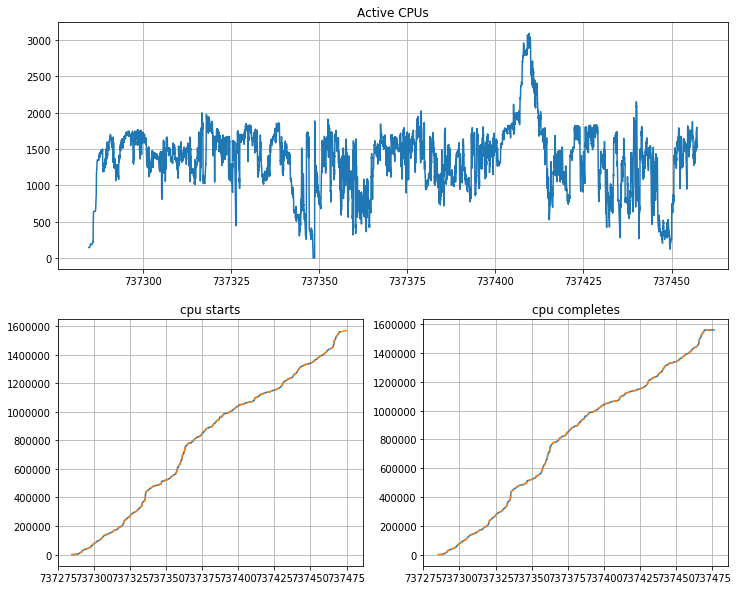

In [147]:
fg = plt.figure(figsize=(12, 10))
ax1 = plt.subplot('211')
ax1.grid()
#
ax2 = plt.subplot('223')
ax2.grid()
ax2.set_title('cpu starts')
#
ax3 = plt.subplot('224')
ax3.grid()
ax3.set_title('cpu completes')
#
#
ax2.plot(*ns_start, ls='-', marker='')
ax3.plot(*ns_end, ls='-', marker='')
#
X = numpy.linspace(numpy.min(numpy.array([t_start[ix_start], t_end[ix_end]])),
                       numpy.max(numpy.array([t_start[ix_start], t_end[ix_end]])), 10000)
ax2.plot(X, f_start(X), ls='--')
ax3.plot(X, f_end(X), ls='--')
#

ax1.plot(X[:-1000], (f_start(X)-f_end(X))[:-1000], ls='-')
ax1.set_title('Active CPUs')

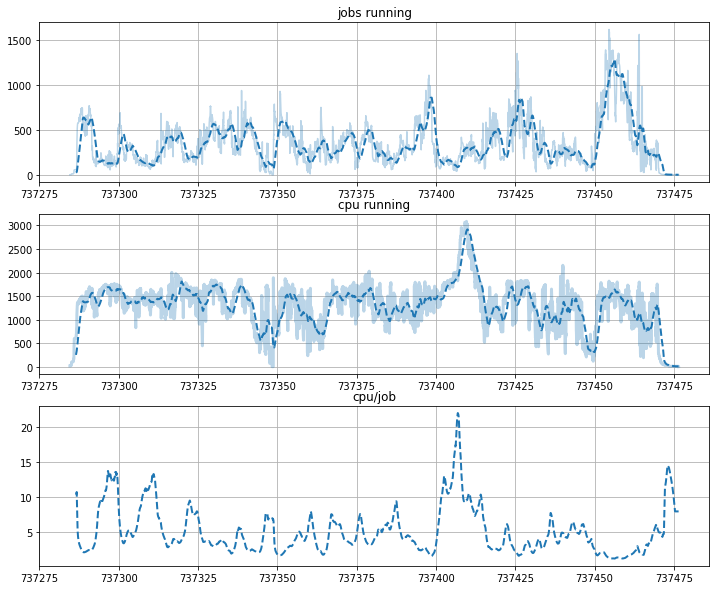

In [148]:
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('311')
ax2 = plt.subplot('312', sharex=ax1)
ax3 = plt.subplot('313', sharex=ax1)
n_ave = 100
#
ln, = ax1.plot(X,Ns, ls='-', lw=1.5, marker='', alpha=.3)
clr = ln.get_color()
#
Ns_sm = (numpy.cumsum(Ns)[n_ave:]-numpy.cumsum(Ns)[:-n_ave])/float(n_ave)
ax1.plot(X[n_ave:], Ns_sm, color=clr,
        ls='--', lw=2.)

ln, = ax2.plot(X, Ns_cpu, ls='-', lw=3., marker='', alpha=.3)
clr = ln.get_color()
Ns_cpu_sm = (numpy.cumsum(Ns_cpu)[n_ave:]-numpy.cumsum(Ns_cpu)[:-n_ave])/float(n_ave)
ax2.plot(X[n_ave:], Ns_cpu_sm, color=clr,
        ls='--', lw=2.)

ax3.plot(X[n_ave:], Ns_cpu_sm/Ns_sm, color=clr,
        ls='--', lw=2.)

#
ax1.set_title('jobs running')
ax2.set_title('cpu running')
ax3.set_title('cpu/job')
#
ax1.grid()
ax2.grid()
ax3.grid()

In [25]:
86*24

2064

*** lens: 1710724, 1539232
[604827. 170854. 170854. 170854. 170872. 170872. 170873. 167621. 167621.
 167626.]


/Users/myoder96/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0.99, 1.001)

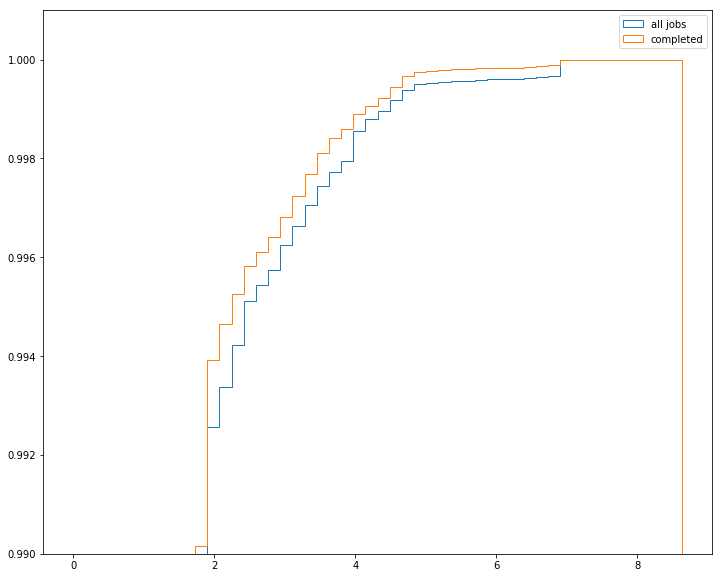

In [13]:

#
# delta_ts_all = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) for rw in data])
# delta_ts_completed = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) 
#                                   for rw in data if rw[RH['State']]=='COMPLETED'])
#
delta_ts_all = numpy.array([rw[RH['Elapsed']] for rw in data])
delta_ts_completed = numpy.array([rw[RH['Elapsed']] 
                                  for rw in data if rw[RH['State']]=='COMPLETED'])
#
print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
#
print(delta_ts_all[0:10])
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = True
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
                  label='all jobs')
hh_comp = ax.hist(delta_ts_completed*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                  label='completed')
#
ax.legend(loc=0)
#
ax.set_ylim(.99,1.001)

Text(0.5, 1.0, 'Cumulative Distribution of Job Lengths')

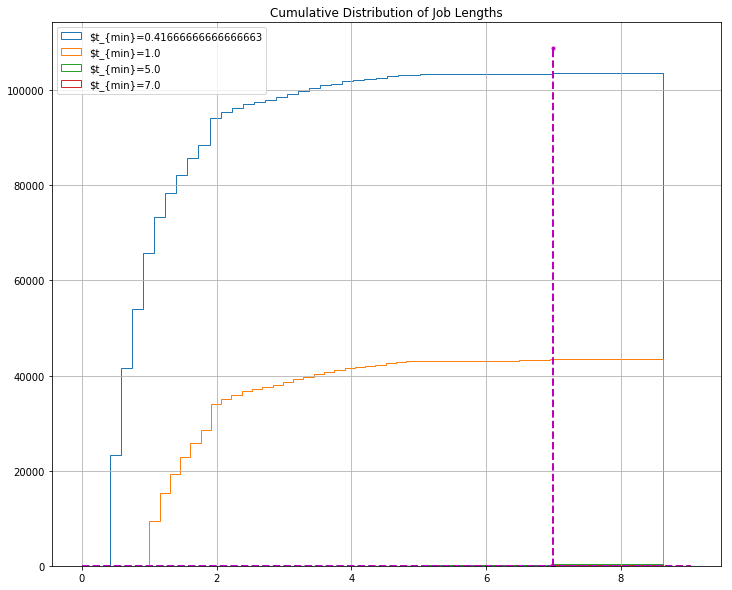

In [14]:
# time delayed plots. aka, probability (or counts) of job times given jobs > t_min
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = False
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
delta_ts_completed = numpy.array([rw[RH['Elapsed']]
                                      for rw in data if rw[RH['State']]=='COMPLETED'])
for k,t_min in enumerate([0., 3600., 36000., 24.*3600, 5.*24.*3600, 7.*24.*3600]):
    if k<2: continue

    #delta_ts_all = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) for rw in data])
    
    #
    #print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
    #
    #print(delta_ts[0:10])
    #
    #
    #hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
    #                  label='all jobs')
    Y,X, patches = ax.hist(delta_ts_completed[delta_ts_completed>= t_min]*time_factor, bins=50,
                           log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                      label='$t_{{min}}={}'.format(t_min*time_factor,))
    #
    # fill bewteen (approximate) dt=7 intersection and y.
    k0 = numpy.argmin( (X-7.)**2. )
    y0 = Y[k0]
    clr = patches[0].get_edgecolor()
    ix = X[:-1]>7.
    #
    X_prime = [X[k0]]
    Y_prime = [Y[k0]]
    for j, (x,y1,y2) in enumerate(zip(X[k0+1:], Y[k0:-1], Y[k0+1:])):
        X_prime += [x, x]
        Y_prime += [y1, y2]
    #
    #ax.fill_between(numpy.array(X[:-1])[ix], y0, Y[ix], color=clr, alpha=.1)
    ax.fill_between(X_prime, y0, Y_prime, color=clr, alpha=.1)
    #print('** ** ', len(ax.lines))
    #
ax.legend(loc=0)
ax.grid()
ax.plot([7., 7.], ax.get_ylim(), marker='.', ls='--', lw=2., color='m')
ax.plot(ax.get_xlim(), [.9, .9], marker='', ls='--', lw=2., color='m')
#
ax.set_title('Cumulative Distribution of Job Lengths')

Text(0.5, 1.0, 'Cumulative Distribution of Usage-index ($\\Delta t \\cdot N_{cpu}$)')

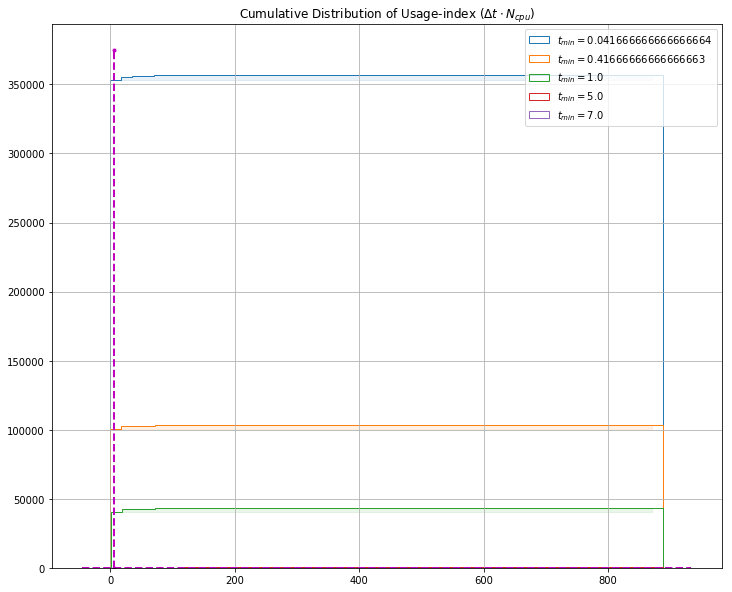

In [66]:
# time delayed plots. aka, probability (or counts) of job times given jobs > t_min
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = False
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
# usage index: dt*ncpus
usage_index_completed = numpy.array([rw[RH['Elapsed']]*float(rw[RH['NCPUS']])
                                      for rw in data if rw[RH['State']]=='COMPLETED'])
for k,t_min in enumerate([0., 3600., 36000., 24.*3600, 5.*24.*3600, 7.*24.*3600]):
    if k<1: continue

    #delta_ts_all = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) for rw in data])
    
    #
    #print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
    #
    #print(delta_ts[0:10])
    #
    #
    #hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
    #                  label='all jobs')
    Y,X, patches = ax.hist(usage_index_completed[delta_ts_completed>= t_min]*time_factor, bins=50,
                           log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                      label='$t_{{min}}={}$'.format(t_min*time_factor,))
    #
    # fill bewteen (approximate) dt=7 intersection and y.
    k0 = numpy.argmin( (X-7.)**2. )
    y0 = Y[k0]
    clr = patches[0].get_edgecolor()
    ix = X[:-1]>7.
    #
    X_prime = [X[k0]]
    Y_prime = [Y[k0]]
    for j, (x,y1,y2) in enumerate(zip(X[k0+1:], Y[k0:-1], Y[k0+1:])):
        X_prime += [x, x]
        Y_prime += [y1, y2]
    #
    #ax.fill_between(numpy.array(X[:-1])[ix], y0, Y[ix], color=clr, alpha=.1)
    ax.fill_between(X_prime, y0, Y_prime, color=clr, alpha=.1)
    #print('** ** ', len(ax.lines))
    #
ax.legend(loc=0)
ax.grid()
ax.plot([7., 7.], ax.get_ylim(), marker='.', ls='--', lw=2., color='m')
ax.plot(ax.get_xlim(), [.9, .9], marker='', ls='--', lw=2., color='m')
#
ax.set_title('Cumulative Distribution of Usage-index ($\Delta t \cdot N_{cpu}$)')

In [16]:
# How 'bout some data on long jobs...
#
long_jobs = [rw for rw in data if rw[RH['Elapsed']]>7*24.*3600]
#
long_jobs_df = data_df[data_df['Elapsed']>7*24.*3600]
#

In [17]:
# partitions using long jobs:
print("Long Job Partitons: ")
print("len: ", len(long_jobs))
print('partitions: ')
#for rw in list(set([s[RH['Partition']] for s in long_jobs])):
for rw in list(set(long_jobs_df['Partition'])):
    print('** ', rw)
    #
#
# partitions using long jobs:
print("Long Job Users: ")
print("len: ", len(long_jobs))
print('Users: ')
for rw in list(set(long_jobs_df['User'])):
    print('** ', rw)
    #
#

Long Job Partitons: 
len:  563
partitions: 
**  
**  hns
Long Job Users: 
len:  563
Users: 
**  
**  jbabicz
**  ogoann
**  jhende
**  czheng16
**  elora
**  akshayaj
**  ajh96
**  wilkinsd
**  prasai
**  adamjcz
**  gusbraun
**  jkozuch
**  jrsmith7
**  lbgee
**  bcornwel


In [18]:
print(headers)

['User', 'Group', 'GID', 'JobID', 'JobName', 'Partition', 'State', 'Submit', 'Timelimit', 'Eligible', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', 'SystemCPU', 'UserCPU', 'TotalCPU', 'Suspended']


In [19]:
total_compute_vol = numpy.sum(data_df['NCPUS']*data_df['Elapsed'])
ix = data_df['Elapsed']>(7.*24.*3600.)
long_compute_vol = numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix])
#
print('** jobs: ', len(data), len(data_df[ix]), sum(ix), len(data_df[ix])/len(data))
print('** compute tinme: ', numpy.sum(data_df['Elapsed']), numpy.sum(data_df['Elapsed'][ix]),
      numpy.sum(data_df['Elapsed'][ix])/numpy.sum(data_df['Elapsed']))
print('** compute volumnes: ', total_compute_vol, long_compute_vol, long_compute_vol/total_compute_vol)


** jobs:  1710724 563 563 0.0003291004276551916
** compute tinme:  17412980970.0 340818511.0 0.019572668894957162
** compute volumnes:  63034588211.0 6565789863.0 0.10416169993879996


/Users/myoder96/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/myoder96/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Job length $t$ [days]')

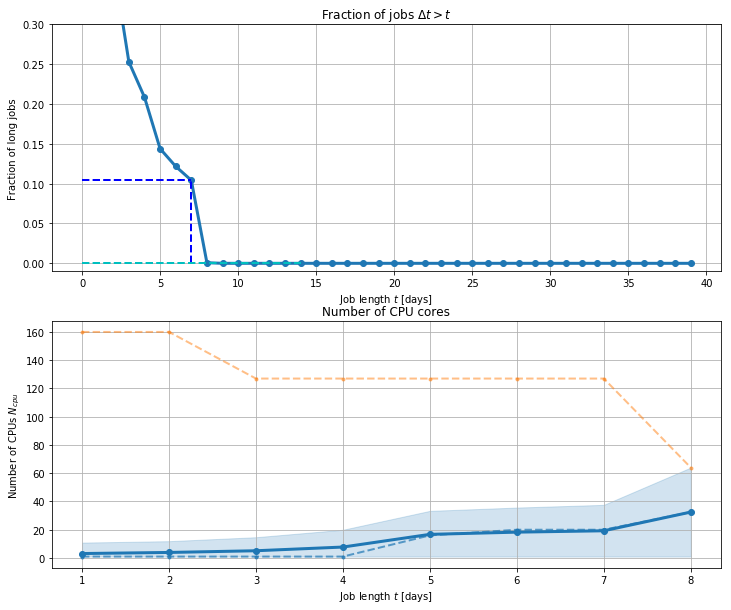

In [20]:
#
ts = numpy.arange(1,40)
lcvs = numpy.zeros(len(ts))
mean_n_cpus = numpy.zeros(len(ts))
stdev_n_cpus = numpy.zeros(len(ts))
max_n_cpus = numpy.zeros(len(ts))
median_n_cpus = numpy.zeros(len(ts))

for k,t in enumerate(ts):
    ix = data_df['Elapsed']>(t*24.*3600.)
    lcv = numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix])
    #
    lcvs[k] = numpy.sum(numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix]))/total_compute_vol
    #
    mean_n_cpus[k]  = numpy.mean(data_df['NCPUS'][ix])
    stdev_n_cpus[k] = numpy.std(data_df['NCPUS'][ix])
    max_n_cpus[k] = numpy.max(data_df['NCPUS'][ix])
    median_n_cpus[k] = numpy.median(data_df['NCPUS'][ix])
    #
#
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax1.grid()
ax2 = plt.subplot('212')
ax2.grid()
#
ax1.plot(ts, lcvs, ls='-', marker='o', lw=3)
ln, ax2.plot(ts, mean_n_cpus, ls='-', marker='o', lw=3)
clr = ln.get_color()
ax2.fill_between(ts, numpy.max([numpy.ones(len(ts)), mean_n_cpus-stdev_n_cpus], axis=0), mean_n_cpus+stdev_n_cpus, alpha=.2, color=clr)
ax2.plot(ts, max_n_cpus, ls='--', marker='.', lw=2., alpha=.5)
ax2.plot(ts, median_n_cpus, ls='--', marker='.', lw=2., alpha=.7, color=clr)
#
#
n = 7
ax1.plot([0., n], [lcvs[n-1], lcvs[n-1]], ls='--', lw=2., color='b')
ax1.plot([n, n], [0., lcvs[n-1]], ls='--', lw=2., color='b')
#
n=14
ax1.plot([0., n], [lcvs[n-1], lcvs[n-1]], ls='--', lw=2., color='c')
ax1.plot([n, n], [0., lcvs[n-1]], ls='--', lw=2., color='c')
#
ax1.set_ylim(-.01, .3)
#
ax1.set_title('Fraction of jobs $\Delta t > t$')
ax1.set_ylabel('Fraction of long jobs')
ax1.set_xlabel('Job length $t$ [days]')

ax2.set_title('Number of CPU cores')
ax2.set_ylabel('Number of CPUs $N_{cpu}$')
ax2.set_xlabel('Job length $t$ [days]')



### Job wait times
- Compute stats (mean, median, stdev) for wait times, as a function of the number of cores, $n_{cpu}$


In [21]:
# Wait times as a funciton of CPU.
#
delta_ts = mpd.date2num(data_df['Start']) - mpd.date2num(data_df['Submit'])
#
# do some binning and stats:
#Ns_cpus = numpy.unique(dat_df['NCPUS'])
Ns_cpu = numpy.arange(max(data_df['NCPUS']))+1
# so we could spin through this and group all the data into bins, like:
# 1: (x10, x11, x12..), 2:(x20, x21, x22...)
# ... or we could sort the data and use a find_in_sorted() type function, but for
#. now, i think it will be sufficient to just spin through the list a few times and use an index:
#
wait_stats = numpy.core.records.fromarrays(numpy.zeros((len(Ns_cpu), 6)).T, dtype=[('n', '>f8'), ('mean', '>f8'), 
                                                                ('median', '>f8'),  ('stdev', '>f8'),
                                                                ('min', '>f8'),  ('max', '>f8')])
#
for k in Ns_cpu:
    #x_prime = delta_ts[data_df['NCPUS']==k]
    x_prime = delta_ts[numpy.logical_and(data_df['NCPUS']==k, delta_ts>=0.)]
    #wait_stats[k-1]=[[k, numpy.mean(x_prime), numpy.median(x_prime), numpy.std(x_prime), 
    #                 numpy.min(x_prime), numpy.max(x_prime)]]
    wait_stats[k-1][0] = k
    if len(x_prime)==0:
        continue
    
    for j,f in zip(range(1, 6), [numpy.mean, numpy.median, numpy.std, numpy.min, numpy.max]):
        #
        wait_stats[k-1][j]=f(x_prime)
#

In [22]:

print('** ', 1./(24*60) )
print('** ', .0007*24.*60)

**  0.0006944444444444445
**  1.008


Text(0, 0.5, 'wait time, hours')

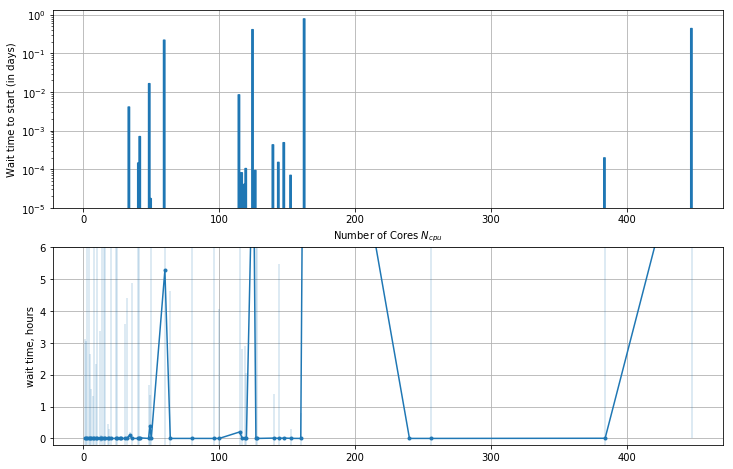

In [90]:
#
# make a step-function of median wait times:
#step_meds = [[0,0]]
step_meds=[]
for x,y in zip(Ns_cpu, wait_stats['median']):
    #x0 = step_meds[-1][0]
    step_meds += [[x-1, 0], [x-1, y], [x,y], [x,0]]
step_meds = numpy.array(step_meds)
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
#ax1 = plt.subplot('111')
ax2 = plt.subplot('212', sharex=ax1)
#
#ln, = ax1.plot(Ns_cpu, wait_stats['mean'])
clr = ln.get_color()
#ax1.plot(Ns_cpu, wait_stats['median'], color=clr, ls='-')
#ax1.plot(Ns_cpu, wait_stats['mean'], color=None, ls='--')
#ax1.fill_between(Ns_cpu, wait_stats['median'], wait_stats['median']+wait_stats['stdev'], color=clr, alpha=.2)
ax1.plot(*step_meds.T, ls='-', marker='')
#
ix = wait_stats['mean']>0.
ln2, = ax2.plot(Ns_cpu[ix], 24.*wait_stats['median'][ix], marker='.', ls='-')
clr2=ln2.get_color()
#
ix = wait_stats['mean']>0.
ax2.errorbar((Ns_cpu)[ix], 24.*(wait_stats['median'])[ix], 24.*(wait_stats['stdev'])[ix],
             color=clr2, ls='', alpha=.2)
#
#ax2.plot(data_df['NCPUS'], delta_ts, ls='', marker='.')
#
ax1.grid()
ax1.set_xlabel('Number of Cores $N_{cpu}$')
ax1.set_ylabel('Wait time to start (in days)')
#ax1.set_ylim(0., .0005)
ax1.set_yscale('log')
#ax2.set_yscale('log')
#
ax2.set_ylim(-.2, 6.0)
ax2.grid()
ax2.set_ylabel('wait time, hours')